<a href="https://colab.research.google.com/github/FurkatUZB/first_one/blob/main/Machine_learningga_tayorgarlik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3-QADAM. Ma'lumotlarni Machine Learning uchun tayyorlash
Keyingi katta qadam ma'lumotlarni ML uchun tayyorlash. Avvalgi qadamlarda biz ma'lumotlarga to'g'ridan-to'g'ri ishlov berib, ularni tahlil qildik. O'zimiz uchun ba'zi kerakli xulosalarni oldik. Qaysidur ustunlardagi qiymatlarni o'zgartirtish, yangi ustunlar yaratish kabi ishlarni rejalashtirib oldik. Umuman olganda, ma'lumotlarg bo'lgan talabni shakllantridik. Navbat shu talablar asosida ma'lumotlarni tayyorlash.

Buning uchun endi biz ma'lumotlar bilan to'g'ridan-to'g'ri emas, funksiyalar orqali ishlaymiz. Ya'ni, avvalgi qismda bajargan barcha jarayonlarnbi funksiyalar yordamida avtomatlashtiramiz.
Bunday qilishimizdan maqsad esa, kelajakda yangi ma'lumotlarga ishlov berishda tayyor funksiyani ishga tushirish orqali ma'lumotlarni bittada bizga kerak ko'rinishga keltirib olamiz.

In [ ]:
import pandas as pd
import numpy as np
import sklearn # scikit-learn kutubxonasi

Boshlanishiga, datasetni qayta yuklaymiz.

In [ ]:
# Onlayn dataset joylashgan manzilini ko'rsatamiaz
URL = "https://github.com/ageron/handson-ml2/blob/master/datasets/housing/housing.csv?raw=true"
df = pd.read_csv(URL)
df.head()

Ma'lumotlarni train va test setga ajratamiz.

Oddiy (muvozanatsiz) train/test set

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Muvozanatli (Stratified) train/test set

In [ ]:
df['income_cat'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# stratified_split.split funksiyasi indekslar qaytaradi
for train_index, test_index in stratified_split.split(df,df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

Ishlash uchun muvozanatli setlarni tanlaymiz.
Bu safar label (basorat qilishimiz kerak bo'lgan) ustun median_house_value ni ham alohida ajratamiz.
Bunga sabab, qolgan ustunlarga qo'llangan o'zgarishlarni labelga ham qo'llamaslik.

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

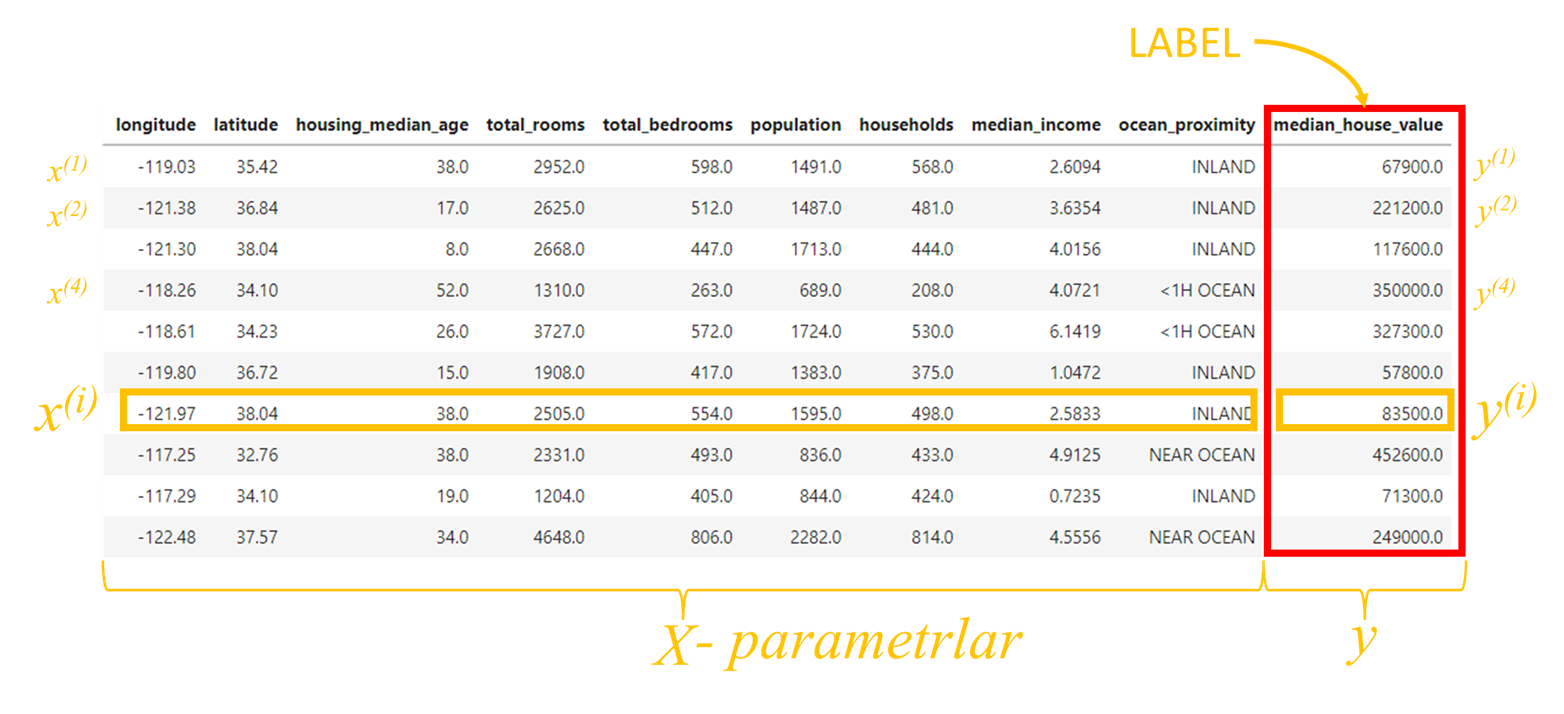

3.1 Tozalash

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB
Esingizda bo'lsa, df.info() yordamida total_bedrooms ustunida ba'zi qatorlarda qiymatlar yo'q (NaN) ekanini aniqlagan edik.

Ushbu qatorlar bizga halaqit bermasligi uchun oldimizda 3 ta yo'l bor:

Qatorlarni (hududlarni) o'chirib tashlash
Bu ustunni umuman tashlab yuborish
NaN qiymatlarni to'ldirish (0, o'rtacha yoki median qiymat bilan)
Bulardan qay birini tanlash, loyihadan loyihaga qarab o'zgaradi. Agar birinchi ikki usulni tansalangiz, buning yo'li oson:

In [ ]:
# 1-variant. Qatorlarni tashlab yuborish
housing.dropna(subset=['total_bedrooms']) # inplace=True qilishni unutmang

In [ ]:
# 2-variant. Ustunni tashlab yuborish
housing.drop("total_bedrooms", axis=1) # inplace=True qilishni unutmang

In [ ]:
# 3-variant. Median qiymat bilan to'ldirish
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median) # inplace=True qilishni unutmang

Biz 3-variantni tanlaymiz va buni biroz takomillashtiramiz.

Gap shundaki, bu safar bizga kelgan datasetda total_bedrooms ustunida NaN qiymatlar bor edi, lekin kelgusida yangi ma'lumotlar kelganda, boshqa, deylik population ustunida NaN qiymatlar bo'lishi mumkin. Biz yuqorida ma'lumotlarga ishlov berishni avtomatlashtirish haqida gapirdik, demak bizning funksiyamiz, har qanday ustundagi NaN qiymatlarni to'ldirib ketishi kerak.

Buning uchun sklearn tarkibida maxsus SimpleImputer funksiyasi mavjud.

In [ ]:
# SimpleImputer klassini chaqiramiz
from sklearn.impute import SimpleImputer
# SimpleImputer klassidan yangi obyekt yaratamiz va NaN qiymatlarni median qiymat bilan to'ldirishni ko'rsatamiz
imputer = SimpleImputer(strategy="median")

Dataset uchun median qiymatni hisoblash uchun imputer obyekti ichidagi .fit() metodiga murojaat qilamiz.
Dataset ustunlariga e'tibor bersak, oxirgi ocean_proximity ustuni sonli emas. imputer esa faqatgina sonli qiymatlar bilan ishlaydi (sonsiz qiymatlarnini o'rta qiymati mavjud emas).

In [ ]:
imputer.fit(housing)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-15-48e4448c63e8> in <module>
----> 1 imputer.fit(housing)

~\Anaconda3\lib\site-packages\sklearn\impute\_base.py in fit(self, X, y)
    275         self : SimpleImputer
    276         """
--> 277         X = self._validate_input(X, in_fit=True)
    278         super()._fit_indicator(X)
    279

~\Anaconda3\lib\site-packages\sklearn\impute\_base.py in _validate_input(self, X, in_fit)
    247                 new_ve = ValueError("Cannot use {} strategy with non-numeric "
    248                                     "data:\n{}".format(self.strategy, ve))
--> 249                 raise new_ve from None
    250             else:
    251                 raise ve

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '<1H OCEAN'
Yuqoridagi xatoning oldini olish uchun, sonli ustunlarni alohida ajratib olamiz:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')
Hisoblangan median qiymatlar statistics_ atrributida saqlanadi:

In [ ]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])
Yuqorida har bir ustun uchun median qiymatni ko'rishingiz mumkin

Datasetdagi NaN qiymatlarni hisoblangan median qiymatlar bilan to'ldirish uchun .transform() funksiyasiga murojaat qilamiz:

In [ ]:
X = imputer.transform(housing_num)

Natijani X o'zgaruvchiga saqladik.

In [ ]:
type(X)

numpy.ndarray
.transform() funksiyasi numpy array qaytaradi. Arrayni qaytarib dataframega o'tkazamiz:

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [ ]:
housing_tr.head()

3.2 Matnli ustunlarni shakl almashtirish
Datasetimizning ocean_proximity ustuni matnli ustun. Keling boshlanishga bu ustunni ajratib olamiz.

In [ ]:
housing_cat = housing[['ocean_proximity']]

In [ ]:
housing_cat["ocean_proximity"].head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object
ML algoritmlar sonlar bilan ishlaydi. Shuning uchun bu ustunni ham sonlarga o'zgartirishimiz kerak.

Buning 2 usuli bor:

Har bir matnni son bilan almashtirish.
Buning uchun sklearn tarkibida OrdinalEncoderdan foydalanamiz:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])
Ko'rib turganingizdek, matnlar sonlar bilan almashdi. Bu usul juda qulay lekin o'ziga yarasha kamchilig bor. Gap shundaki ML algoritm ikki yaqin songa mos keluvchi qatorlar bir-biriga yaqin deb qabul qiladi. Agar bu haqiqatdan shunday bo'lsa, model to'g'ri ishlaydi, lekin bu narsa haqiqatga to'g'ri kelmasa kelajakda model ishlashida noaniqlik baland bo'ladi.

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]
Bizda, ahamiyat bersangiz qo'shni qiymatlar (matnlar) bir-biriga yaqin emas. <1H OCEAN va INLAND ga 0.0 va 1.0 qiymatlari berilgan, vaholanki, mantiqan o'ylansa bu ikkisi bir-biridan uzoq. NEAR BAY, NEAR OCEAN qiymatlari esa aksincha, <1H OCEANdan uzoqlashib ketgan.

OneHotEncoder - usuli yordamida har bir noyob qiymat alohida ustunga aylanadi va mos keluvchi ustunga 1, qolganlariga 0 qo'yiladi. Tushunarli bo'lishi uchun keyingi kodga ahamiyat bering.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])
Yuqorida nima bo'ldi, bizda 5 ta kategoriya bor edi ('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN').

OneHotEncoder 5 ta ustundan iborat yangi matrisa yaratdi. Har bir ustun yuqoridagi bitta kategoriyaga mos keladi: 1-ustun:'<1H OCEAN', 2-ustun:'INLAND' va hokazo.
Endi, har bir qatordagi matnning qiymatiga qarab mos keluvchi ustunga 1 qo'yiladi (qolgani 0 bo'ladi).

Masalan, housing_cat dataset 1-qatorini ko'rsak, <1H OCEAN qiymati turibdi, demak matrisaning 1-ustuni 1 qolganlari 0 bo'ladi. Buni yuoqridagi katakda ko'rishimiz mumkin.

In [ ]:
housing_cat.head(10)


Birinchi yoki ikkinchi usuldan qayerda foydalanish sizga havola. Agar matnli qiymatlarning turi judayam ko'p bo'lsa 2-usul datasetning kattalshib ketishiga sabab bo'ladi. Yuqorida, bizda 5 ta kategoriya bo'lgani uchun, datasetga yana 5 ta ustun qo'shishimiz kerak, bizda 16512 qator borligini hisobga olsak bu 82560 ta qo'shimcha qiymat degani.

Demak kategoriyalar soni oshgan sari, ishlov berish kerak bo'lgan ustunlar ham oshib ketadi bu esa ortiqcha resurs ishlatilishiga va qo'shimcha moliyaviy harajatlarga olib keladi.
3.3 Transfomer
Yuqorida ma'lumotlarg ishlov berishda biz sklearn tarkibidagi tayyor obyektlar va ulardagi .fit() yoki .fit_transform() funksiyalariga murojaat qildik.
Bu funksiyalar (imputer, OneHotEncoder va hokazo) transformerlar deb ataladi.

Umuman olganda sklearn tarkibidagi obyektlar uch turli bo'ladi:

Estimator - tahmin qiluvchi (baholovchi) funksiyalar. Bunday obyektlar .fit() metodiga ega bo'ladi, bu metod berilgan ma'lumotlardan qandaydur qiymatni hisoblaydi (masalan, avvalroq biz imputer.fit() yordamida median qiymatni hisobladik)
Transformer - ham tahmin qilib ham ma'lumotga ishlov beruvchi obyekt. Bunday obyektlar .fit_transform() metodiga ega bo'ladi, ya'ni avval qandaydur qiymatnbi hisoblaydi, keyin esa hisoblashni ma'lumotlarga qo'llaydi. Yuoqirdagi OrdinalEncoder va OneHotEncoder shunday obyektlardan.
Predictor - bashorat qiluvchi obyektlar. Bunday obyektlar .predict() metodiga ega bo'ladi. Ular biz bergan ma'lumotlar asosida bashoratlar qaytaradi. Dars davomida predictor obyektlar bilan ko'p ishlaymiz.
Obyektlarning afzalligi, ular hisob kitob natijalarini ichki attributrlarda saqlab qoladi. Masalan, yuqorida ko'rganimiz imputer.statistics_.

Keling endi o'zimiz ham transformer yozishni o'rganamiz.

Esingizda bo'lsa, avvalgi darsimizda biz ma'lumotlarg yangi 2 ustun qo'shdik: rooms_per_household va bedrooms_per_room.

Keling berilgan ma'lumotlarga shu ikki ustunni avtomat ravishda qo'shadigan transformer yasaymiz.

Buning uchun sklearn tarkibida BaseEstimator va TransformerMixin klasslaridan meros olib yangi klass yasaymiz va bu klassimizga kabi fit() va transform() metodlarini qo'shamiz:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# bizga kerak ustunlar indekslari
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # bizni funksiyamiz faqat transformer. estimator emas
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: # add_bedrooms_per_room ustuni ixtiyoriy bo'ladi
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[0,:]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN', 4.625368731563422, 2.094395280235988,
       0.22385204081632654], dtype=object)

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[0,:]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN', 4.625368731563422, 2.094395280235988], dtype=object)
3.4 Standartizasiya va normalizasiya
Ahamiyat bersangiz, bizdagi ustunlardagi qiymatlar diapazoni turlicha, masalan:

housing_median_age - 0-50 oralig'ida
total_rooms esa 6-39000 oralig'ida
median_income - 0.5-15 oralig'ida
Bularning hammasi kelgusi hisob kitoblarda algoritmlarning to'gri ishlashiga ta'sir ko'rsatadi.

Buning oldini olish uchun barcha ustundagi qiymatlarni bir diapazonga keltirib olish tavsiya qilinadi.

Buning uchun ML da min-max normallashtirish (min-max scaling) yoki standartlash (standartization) qo'llaniladi.

3.4.1 Min-max scaling
Min-max scaling berilgan qiymatlarni 0-1 oralig'iga olib keladi.

Buning uchun biror ustundagi barcha qiymatlarning min (

x
min
​
 ) va max (

x
max
​
 ) qiymatlari topiladi. Keyin esa ustundagi har bir qiymat (
�
x) quyidagi formula asosida hisoblab chiqiladi:
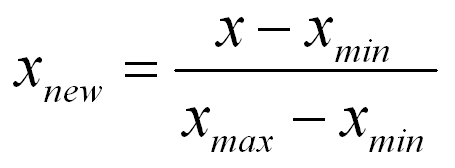
alt

Yuqoridagi vazifani bajarish uchun sklearn tarkibida maxsus MinMaxScaler obyekti bor. Keling, min-max scalingni bizdagi ma'lumotlarga qo'llab ko'ramiz:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_mix_scaler = MinMaxScaler()

min_mix_scaler.fit_transform(housing_num)

array([[0.24501992, 0.50478215, 0.7254902 , ..., 0.01981558, 0.06292009,
        0.15201859],
       [0.24103586, 0.47927736, 0.25490196, ..., 0.00849239, 0.02072442,
        0.40837368],
       [0.71215139, 0.02444208, 0.58823529, ..., 0.02614984, 0.08588499,
        0.1629081 ],
       ...,
       [0.79183267, 0.16471838, 0.15686275, ..., 0.05871801, 0.14245706,
        0.19119736],
       [0.6314741 , 0.1360255 , 0.58823529, ..., 0.03792147, 0.0660941 ,
        0.24569316],
       [0.18924303, 0.55579171, 1.        , ..., 0.03548306, 0.11893204,
        0.21207294]])
Ko'rib turganingizdek, sonlar 0-1 oralig'iga keldi.

3.4.2 Standard Scaler - standartlash
StandardScaler biroz boshqa usulda ishlaydi. Sonlarni standartlas hcuhn bizga berilgan ustun bo'yicha o'rta qiymat (
�
μ) va standart cheklanish (
�
σ) talab qilinadi. Har bir qatordag qiymat esa quydagicha hisoblanadi 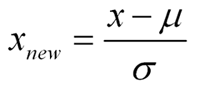

In [ ]:
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

In [ ]:
housing.head()


longitude	latitude	housing_median_age	total_rooms	total_bedrooms	population	households	median_income	ocean_proximity
17606	-121.89	37.29	38.0	1568.0	351.0	710.0	339.0	2.7042	<1H OCEAN
18632	-121.93	37.05	14.0	679.0	108.0	306.0	113.0	6.4214	<1H OCEAN
14650	-117.20	32.77	31.0	1952.0	471.0	936.0	462.0	2.8621	NEAR OCEAN
3230	-119.61	36.31	25.0	1847.0	371.0	1460.0	353.0	1.8839	INLAND
3555	-118.59	34.23	17.0	6592.0	1525.0	4459.0	1463.0	3.0347	<1H OCEAN

In [ ]:
housing_onehot = pd.get_dummies(housing['ocean_proximity'])
housing_onehot

In [ ]:
housing_num.head()